In [1]:
%matplotlib inline
import waves
import matplotlib.pyplot as plt
import numpy as np

A/D conversion
=============

In [2]:
CD = waves.CDFormatSampler('CD')
SACD = waves.PCMSampler('SACD', 64 * 44100, 16)
DVDA = waves.PCMSampler('DVDA', 192000, 2)
# Generic, define sampling frequency (Hz) and resolution (bits) to your heart's content
GenericPCM = waves.PCMSampler('Generic', 44100, 4)

CD stream: [32768 37420 41979 46351 50447 54186 57490 60293 62539 64181 65186 65535
 65219 64246 62635 60419 57642 54362 50643 46563 42203 37651 33001 28346
 23780 19397 15285 11527  8199  5369  3095  1422   384     2   284  1225
  2804  4991  7741 10998 14697 18761 23109 27653 32301]
DVDA stream: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
Generic stream: [ 8  9 10 11 12 12 13 14 14 15 15 15 15 15 14 14 13 12 12 11 10  9  8  6
  5  4  3  3  2  1  1  0  0  0  0  0  1  1  2  3  3  4  5  6  7]


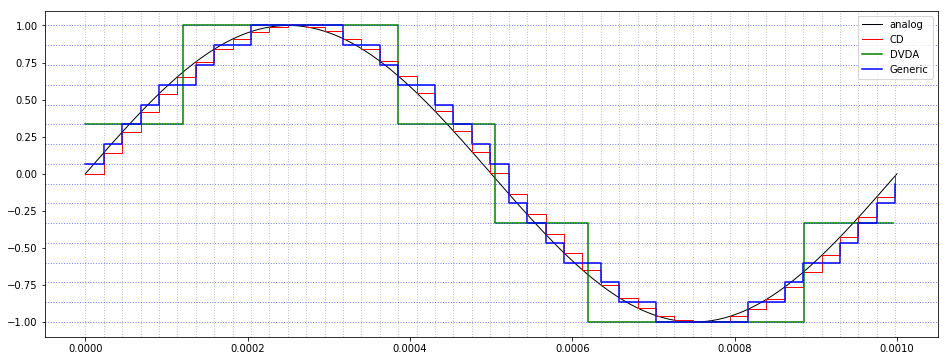

In [3]:
f = 1e3 # 1KHz
audio = waves.AnalogSineWave('analog', f, phase=0)
n_waves = 1
length = n_waves * 1/f

audio.plot(length, plt, color='k', lw=1)
CD.sample(audio, length, plt, color='r', lw=1.0)
#SACD.sample(audio, length, plt, color='b', lw=1.5)
DVDA.sample(audio, length, plt, color='g', lw=1.5)
GenericPCM.sample(audio, length, plt, color='b', lw=1.5)
[plt.axvline(t, color='grey', lw=1, ls=':', alpha=0.5) for t in np.arange(0, length, CD.sampling_interval)]
[plt.axhline(A, color='b', lw=1, ls=':', alpha=0.5) for A in np.linspace(audio.Amin, audio.Amax, GenericPCM.levels)]
plt.legend()
plt.gcf().set_size_inches(16, 6)